Device: cpu
Number of samples: 419509
a_r = 0.5
b_r = 0.6
Epoch 0 | D Loss: 1.3947 | G Loss: 0.7412
Epoch 500 | D Loss: 1.3698 | G Loss: 0.6954
Epoch 1000 | D Loss: 1.4627 | G Loss: 0.6776
Epoch 1500 | D Loss: 1.4032 | G Loss: 0.6714
Epoch 2000 | D Loss: 1.3936 | G Loss: 0.6901
Epoch 2500 | D Loss: 1.3827 | G Loss: 0.7042


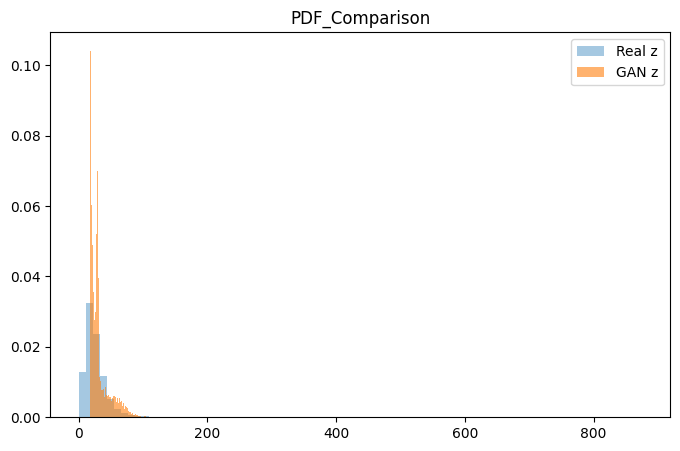

Histogram saved as 'histogram.png'


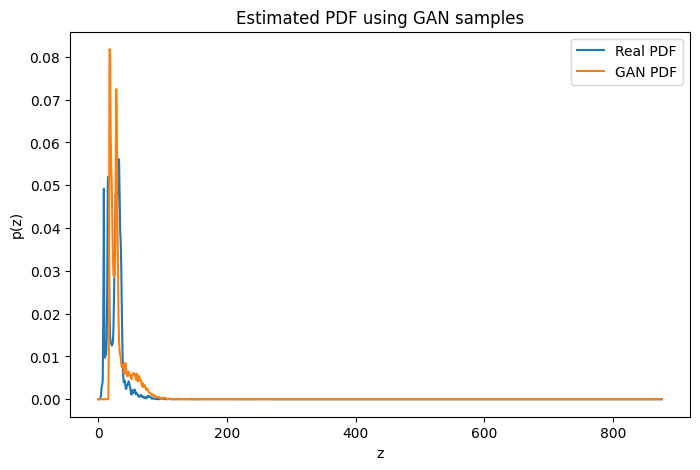

KDE Plot saved as 'kde_plot.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim

# Checking device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load data
df = pd.read_csv("data.csv", encoding='latin1', low_memory=False)

# Extracting the feature NO2 (x)
# 'coerce' handles any non-numeric errors in the column
x = pd.to_numeric(df["no2"], errors='coerce').dropna().values.astype(np.float32)
print("Number of samples:", len(x))

# Applying Transformation
r = 102303706
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)
print("a_r =", a_r)
print("b_r =", b_r)

# Normalizing Z
z_mean = z.mean()
z_std = z.std()
z_norm = (z - z_mean) / z_std
z_tensor = torch.tensor(z_norm).view(-1, 1).to(device)

# Designing of the Generator in GAN
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Designing of the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Optimizers and Loss
criterion = nn.BCELoss()
g_opt = optim.Adam(G.parameters(), lr=0.0002)
d_opt = optim.Adam(D.parameters(), lr=0.0002)

epochs = 3000
batch_size = 128

for epoch in range(epochs):
    # Select random real samples
    idx = torch.randint(0, z_tensor.size(0), (batch_size,))
    real = z_tensor[idx]

    # Train Discriminator
    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise).detach()

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    d_loss = criterion(D(real), real_labels) + criterion(D(fake), fake_labels)

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    # Train Generator
    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise)

    g_loss = criterion(D(fake), real_labels)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generating Samples
G.eval()
with torch.no_grad():
    noise = torch.randn(10000, 1).to(device)
    gen_z = G(noise).cpu().numpy()

# De-normalize
gen_z = gen_z * z_std + z_mean

# PDF Approximation
# 1. Histogram
plt.figure(figsize=(8, 5))
plt.hist(z, bins=80, density=True, alpha=0.4, label="Real z")
plt.hist(gen_z, bins=80, density=True, alpha=0.6, label="GAN z")
plt.title("PDF_Comparison")
plt.legend()
plt.savefig("histogram.png")
plt.show()
print("Histogram saved as 'histogram.png'")

# 2. KDE Plot
gen_z = gen_z.reshape(-1, 1)
z_vals = z.reshape(-1, 1)

kde_gen = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(gen_z)
# Using subset of real data (for faster plotting)
kde_real = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(z_vals[:10000])

z_range = np.linspace(min(z.min(), gen_z.min()), max(z.max(), gen_z.max()), 1000).reshape(-1, 1)

log_dens_gen = kde_gen.score_samples(z_range)
log_dens_real = kde_real.score_samples(z_range)

plt.figure(figsize=(8, 5))
plt.plot(z_range, np.exp(log_dens_real), label='Real PDF')
plt.plot(z_range, np.exp(log_dens_gen), label='GAN PDF')
plt.title("Estimated PDF using GAN samples")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.legend()
plt.savefig("kdePlot.png")
plt.show()
print("KDE Plot saved as 'kde_plot.png'")